In [1]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
def split_based_hour(data):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    N = int(0.8*len(data))
    data = data.sort_values(by="hour")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()

In [3]:
def reg_target_encoding(train, col = "device_type", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    # YOUR CODE HERE
    kf = KFold(n_splits=splits, random_state=None, shuffle=False)
    #train = train.sort_values(by='hour')
    for train_index, val_index in kf.split(train):
        train_tr = train.iloc[train_index].copy()
        col_mean = train_tr.groupby(col).click.mean()
        train.loc[val_index, col+'_mean_enc'] = train.loc[val_index, col].map(col_mean)
    global_mean = train.click.mean()
    train[col+'_mean_enc'].fillna(global_mean, inplace=True)

In [4]:
def mean_encoding_test(test, train, col = "device_type"):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    
    mean_col_type = train.groupby(col).click.mean()
    test[col+'_mean_enc'] = test[col].map(mean_col_type)
    global_mean = train.click.mean()
    test[col+'_mean_enc'].fillna(global_mean, inplace=True)

In [6]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

In [10]:
types = {'id': np.uint32, 'click': np.uint8, 'hour': np.uint32, 'C1': np.uint16, 'banner_pos': np.uint16,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint8, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}

test_types = {'id': np.uint32, 'hour': np.uint32, 'C1': np.uint16, 'banner_pos': np.uint16,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint8, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}

def my_load_data():
    path = 'avazu/'
    data = pd.read_csv(path + 'train', usecols=types.keys(), dtype=types)
    test = pd.read_csv(path + 'test', usecols=test_types.keys(), dtype=test_types)
    return data,test

In [11]:
data, test = my_load_data()

In [8]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 23 columns):
id                  uint32
click               uint8
hour                uint32
C1                  uint16
banner_pos          uint16
site_id             category
site_domain         category
site_category       category
app_id              category
app_domain          category
app_category        category
device_id           category
device_ip           category
device_model        category
device_type         uint8
device_conn_type    uint8
C15                 uint16
C16                 uint16
C17                 uint16
C18                 uint8
C19                 uint16
C20                 uint16
C21                 uint16
dtypes: category(9), uint16(8), uint32(2), uint8(4)
memory usage: 2.8 GB


## Train Validation Split

In [11]:
train,val = split_based_hour(data)

## click mean of entire data set

In [24]:
p_click = train.click.mean()

In [25]:
p_click # should be teh best constant prediction

0.17146870531224626

## Time Feature

In [12]:
def process_time(df, col):
    df[col] = pd.to_datetime(df[col],format='%y%m%d%H')
    df['dow'] = df[col].dt.weekday
    df['hour_24'] = df[col].dt.hour
    df.drop(col, axis=1, inplace=True)
    return df

In [13]:
train = process_time(train, 'hour')
val = process_time(val, 'hour')

In [28]:
train['dow'].value_counts()

1    9375969
2    5337126
3    3870752
6    3835892
5    3363122
4    3335302
0    3225010
Name: dow, dtype: int64

In [29]:
train['hour_24'].value_counts().head() 

13    1944962
9     1894252
12    1775172
8     1729277
14    1720095
Name: hour_24, dtype: int64

Text(0,0.5,'click_rate')

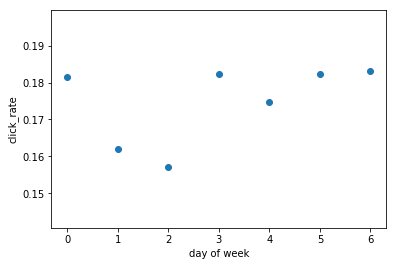

In [30]:
dow_click_rate = train.groupby('dow').agg({'click': 'mean'}).reset_index()
plt.scatter(dow_click_rate['dow'], dow_click_rate['click'])
plt.xlabel("day of week")
plt.ylabel("click_rate")

Text(0,0.5,'click_rate')

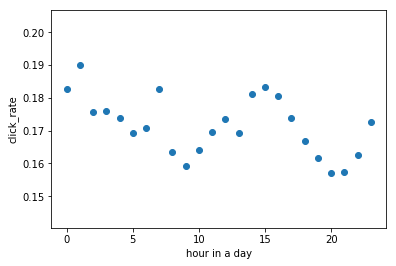

In [31]:
hour_click_rate = train.groupby('hour_24').agg({'click': 'mean'}).reset_index()
plt.scatter(hour_click_rate['hour_24'], hour_click_rate['click'])
plt.xlabel("hour in a day")
plt.ylabel("click_rate")

- for the time feature, both day of week and hour in a day shows regular relationship with click rate (sum(click)/len)
- dow and hour should be important features to predict click
- hour_24 and dow could be used to do **target encode**

## For category data

In [14]:
cat_col = ['id', 'site_id','site_domain', 'site_category', 
           'app_id','app_domain', 'app_category', 
           'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type']

In [33]:
print(len(train.id.unique())) 
print(len(train.device_id.unique())) 
print(len(train.device_ip.unique())) # Too much to do any meaningful encoding, just drop

32221780
2216415
5563626


### Site information

In [36]:
print(len(train.site_id.unique())) # do hash encoder
print(len(train.site_domain.unique())) # do hash encoder
print(len(train.site_category.unique()))

4551
7297
26


Text(0,0.5,'click_rate')

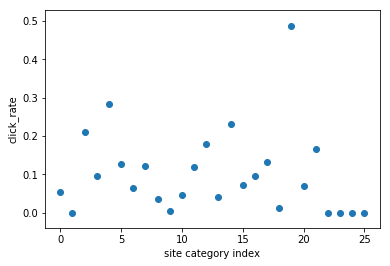

In [37]:
# site category
sitecat_click_rate = train.groupby('site_category').agg({'click': 'mean'}).reset_index()
plt.scatter(range(len(train.site_category.unique())), sitecat_click_rate['click'])
plt.xlabel("site category index")
plt.ylabel("click_rate")

- There are some different click rates in different site type, consider to do a mean target encoding

In [39]:
sitecat_click_rate.sort_values(by='click', ascending=False).head()

,site_category,click
19,dedf689d,0.488327
4,3e814130,0.283179
14,42a36e14,0.230314
2,28905ebd,0.211476
12,f028772b,0.179730


In [15]:
site_cat_dict = {'dedf689d':'dedf689d', '3e814130':'3e814130',
                '42a36e14': '42a36e14', '28905ebd':'28905ebd',
                'f028772b':"f028772b"}

### app info

In [41]:
print(len(train.app_id.unique())) # do hash encoder
print(len(train.app_domain.unique())) # do hash encoder
print(len(train.app_category.unique()))

8094
539
36


Text(0,0.5,'click_rate')

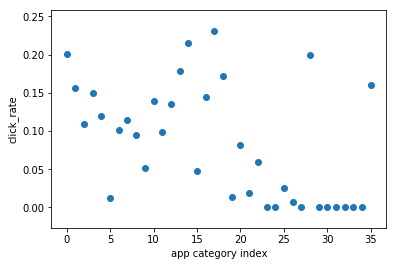

In [42]:
appcat_click_rate = train.groupby('app_category').agg({'click': 'mean'}).reset_index()
plt.scatter(range(len(train.app_category.unique())), appcat_click_rate['click'])
plt.xlabel("app category index")
plt.ylabel("click_rate")

- Some app categories have very low click rate, like 0

In [43]:
appcat_click_rate.sort_values(by='click', ascending=False).head()

,app_category,click
17,8df2e842,0.231187
14,f95efa07,0.215271
0,07d7df22,0.200852
28,71af18ce,0.200000
13,dc97ec06,0.178443


In [18]:
app_cat_dict = {'8df2e842':'8df2e842', 'f95efa07':'f95efa07',
               '07d7df22':'07d7df22', '71af18ce':'71af18ce',
               'dc97ec06':'dc97ec06'}

### Device info

In [45]:
print(len(train.device_model.unique())) # do hash encoder
print(len(train.device_type.unique()))
print(len(train.device_conn_type.unique()))

8036
5
4


Text(0,0.5,'click_rate')

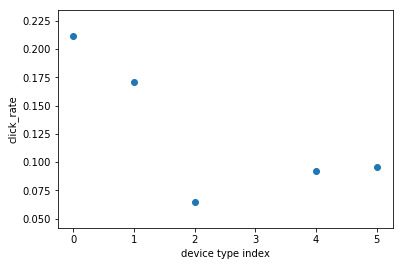

In [46]:
dev_click_rate = train.groupby('device_type').agg({'click': 'mean'}).reset_index()
plt.scatter(dev_click_rate.device_type, dev_click_rate['click'])
plt.xlabel("device type index")
plt.ylabel("click_rate")

Text(0,0.5,'click_rate')

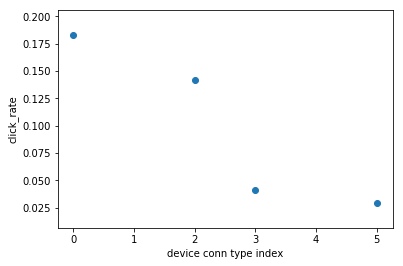

In [47]:
dev_conn_click_rate = train.groupby('device_conn_type').agg({'click': 'mean'}).reset_index()
plt.scatter(dev_conn_click_rate.device_conn_type, dev_conn_click_rate['click'])
plt.xlabel("device conn type index")
plt.ylabel("click_rate")

- both device conn type and device type should be used to do target encoding

## Summary of Category data
- drop id, device_id, device_ip
- For all categorical data, there are two ways to do encoding
    - **hasher**: site_id, site_domain, app_id, app_domain, device_model
    - **target encoding**: dow, hour_24, device_conn_type, device_type
    - **OneHotEncoding**: For app_category and site_category, keep the top 5 according to click rate and convert others to others

### OneHotEncoding

In [16]:
def keep_top5_OHE(df, col, col_dict):
    df[col] = df[col].map(col_dict).fillna('others')
    df_ohe = pd.get_dummies(
        df[col],prefix=col, prefix_sep='_').astype(np.uint8)
    df = df.reset_index(drop=True)
    df_ohe = df_ohe.reset_index(drop=True)
    # if there is no that key in test set, add feature with all zero
    for key in col_dict.keys():
        if (col+ '_' + key) in df_ohe.columns:
            pass
        else:
            df_ohe[col+ '_' + key]=0
    df = pd.concat([df, df_ohe], axis=1)
    df.drop(col, inplace=True, axis=1)
    return df

In [19]:
train = keep_top5_OHE(train, 'app_category', app_cat_dict)
val = keep_top5_OHE(val, 'app_category', app_cat_dict)
train = keep_top5_OHE(train, 'site_category', site_cat_dict)
val = keep_top5_OHE(val, 'site_category', site_cat_dict)

In [46]:
val.columns

Index(['index', 'id', 'click', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'app_id', 'app_domain', 'device_id', 'device_ip', 'device_model',
       'device_type', 'device_conn_type', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C20', 'C21', 'dow', 'hour_24', 'app_category_07d7df22',
       'app_category_8df2e842', 'app_category_dc97ec06',
       'app_category_f95efa07', 'app_category_others', 'app_category_71af18ce',
       'site_category_28905ebd', 'site_category_3e814130',
       'site_category_42a36e14', 'site_category_dedf689d',
       'site_category_f028772b', 'site_category_others'],
      dtype='object')

In [47]:
len(train.columns),len(val.columns)

(35, 35)

### mean target encoding

In [20]:
t_col = ["dow", "hour_24", "device_conn_type", "device_type"]
for t_c in t_col:
    reg_target_encoding(train, col = t_c)
    mean_encoding_test(val, train, col=t_c)
    print(t_c + 'mean target encoding finished')

dowmean target encoding finished
hour_24mean target encoding finished
device_conn_typemean target encoding finished
device_typemean target encoding finished


### hash encoding

In [21]:
#class sklearn.feature_extraction.FeatureHasher(n_features=1048576, 
#input_type=’dict’, dtype=<class ‘numpy.float64’>, alternate_sign=True, non_negative=False)[source]¶
from sklearn.feature_extraction import FeatureHasher
def hash_col(df_train, df_test, col, h_num=10):
    h = FeatureHasher(n_features=h_num,input_type = 'string')
    D_train = df_train[col].values
    D_test = df_test[col].values
    f_train = h.transform(D_train)
    f_test = h.transform(D_test)
    
    df_h_tr = pd.SparseDataFrame(f_train).fillna(0).astype(np.int8)
    df_h_tr.columns = [(col + '_' + str(c)) for c in df_h_tr.columns]
    
    df_h_te = pd.SparseDataFrame(f_test).fillna(0).astype(np.int8)
    df_h_te.columns = [(col + '_' + str(c)) for c in df_h_te.columns]
    
    df_train = df_train.drop(col, axis=1)
    df_train = df_train.reset_index(drop=True)
    df_h_tr = df_h_tr.reset_index(drop=True)
    df_train = pd.concat([df_train, df_h_tr], axis=1)
    
    df_test = df_test.drop(col, axis=1)
    df_test = df_test.reset_index(drop=True)
    df_h_te = df_h_te.reset_index(drop=True)
    df_test = pd.concat([df_test, df_h_te], axis=1)
    return df_train, df_test

In [22]:
h_col = ["site_id", "site_domain", "app_id", "app_domain", "device_model"]
for h_c in h_col:
    train, val = hash_col(train, val, h_c)
    print(h_c + "hash encoding finished")

site_idhash encoding finished
site_domainhash encoding finished
app_idhash encoding finished
app_domainhash encoding finished
device_modelhash encoding finished


In [58]:
train.columns

Index(['index', 'id', 'click', 'C1', 'banner_pos', 'device_id', 'device_ip',
       'device_type', 'device_conn_type', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C20', 'C21', 'dow', 'hour_24', 'app_category_07d7df22',
       'app_category_71af18ce', 'app_category_8df2e842',
       'app_category_dc97ec06', 'app_category_f95efa07', 'app_category_others',
       'site_category_28905ebd', 'site_category_3e814130',
       'site_category_42a36e14', 'site_category_dedf689d',
       'site_category_f028772b', 'site_category_others', 'dow_mean_enc',
       'hour_24_mean_enc', 'device_conn_type_mean_enc', 'device_type_mean_enc',
       'site_id_0', 'site_id_1', 'site_id_2', 'site_id_3', 'site_id_4',
       'site_id_5', 'site_id_6', 'site_id_7', 'site_id_8', 'site_id_9',
       'site_domain_0', 'site_domain_1', 'site_domain_2', 'site_domain_3',
       'site_domain_4', 'site_domain_5', 'site_domain_6', 'site_domain_7',
       'site_domain_8', 'site_domain_9', 'app_id_0', 'app_id_1', 'app_id_2',
   

### drop meaningless columns

In [23]:
drop_col = ["id", "device_id", "device_ip"]
for d_c in drop_col:
    train.drop(d_c, inplace=True, axis=1)
    val.drop(d_c, inplace=True, axis=1)

In [52]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32343173 entries, 0 to 32343172
Data columns (total 81 columns):
index                        int64
click                        uint8
C1                           uint16
banner_pos                   uint16
device_type                  uint8
device_conn_type             uint8
C15                          uint16
C16                          uint16
C17                          uint16
C18                          uint8
C19                          uint16
C20                          uint16
C21                          uint16
dow                          int64
hour_24                      int64
app_category_07d7df22        uint8
app_category_71af18ce        uint8
app_category_8df2e842        uint8
app_category_dc97ec06        uint8
app_category_f95efa07        uint8
app_category_others          uint8
site_category_28905ebd       uint8
site_category_3e814130       uint8
site_category_42a36e14       uint8
site_category_dedf689d       uint8
si

## Fit Model

### Simple Model

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
X_train = train.drop('click', axis=1)
y_train = train.click
X_test = val.drop('click', axis=1)
y_test = val.click

In [54]:
X_train.shape,X_test.shape

((32343173, 80), (8085794, 80))

In [63]:
clf = RandomForestClassifier(n_jobs = -1, n_estimators=10, min_samples_leaf=100, max_features=3, verbose=2)
clf.fit(X_train, y_train)

building tree 1 of 10building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10building tree 8 of 10
building tree 9 of 10building tree 10 of 10





[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 28.5min remaining: 28.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 29.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [25]:
def compute_loss(clf, X_train, y_train, X_test, y_test):
    y_pred_te = clf.predict_proba(X_test)
    y_pred_tr = clf.predict_proba(X_train)
    loss_train = log_loss(y_train, y_pred_tr)
    loss_test = log_loss(y_test, y_pred_te)
    print("log loss on training set is {:0.4f}".format(loss_train))
    print("log loss on test set is {:0.4f}".format(loss_test))

In [71]:
compute_loss(clf, X_train, y_train, X_test, y_test)

[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   25.5s remaining:   59.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   26.4s finished


log loss on training set is 0.3997
log loss on test set is 0.4402


### Model Tuning

In [ ]:
# previous one is overfitting --> increase number of trees and min_samples_leaf

# from sklearn.model_selection import ParameterGrid
# param_grid = {'n_estimators': [20,30], 'min_samples_leaf': [100, 200]}
# grid = list(ParameterGrid(param_grid))

In [27]:
# for params in grid:
#     print(params)
# n_estimators=20, min_samples_leaf=200
clf = RandomForestClassifier(n_jobs = -1, verbose=2, 
                             criterion = 'entropy',
                             n_estimators=20, min_samples_leaf=200)
clf.fit(X_train, y_train)
compute_loss(clf, X_train, y_train, 
             X_test, y_test)

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20building tree 7 of 20building tree 8 of 20building tree 9 of 20building tree 10 of 20



building tree 11 of 20building tree 12 of 20


building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 77.3min remaining: 116.0min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 102.3min finished
[Parallel(n_jobs=12)]: Done   8 out of  20 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    6.0s finished
[Parallel(n_jobs=12)]: Done   8 out of  20 | elapsed:   30.4s remaining:   45.6s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:  1.0min finished


log loss on training set is 0.3939
log loss on test set is 0.4009


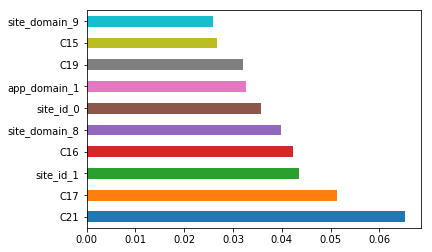

In [33]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10).plot(kind='barh')

### Results
- The model with n_estimators=20 and min_samples_leaf=200 did a great job in modeling, the hash encoding and numerical features are very important
- The log loss on test set is 0.4

# Final Modeling Fit

In [12]:
def process_time(df, col):
    df[col] = pd.to_datetime(df[col],format='%y%m%d%H')
    df['dow'] = df[col].dt.weekday
    df['hour_24'] = df[col].dt.hour
    df.drop(col, axis=1, inplace=True)
    return df

In [13]:
data = process_time(data, 'hour')

In [18]:
test = process_time(test, 'hour')

In [14]:
sitecat_click_rate = data.groupby('site_category').agg({'click': 'mean'}).reset_index()
sitecat_click_rate.sort_values(by='click', ascending=False).head()

,site_category,click
19,dedf689d,0.514000
4,3e814130,0.283003
14,42a36e14,0.231014
2,28905ebd,0.208019
12,f028772b,0.179579


In [15]:
site_cat_dict = {'dedf689d':1, '3e814130':2,
                '42a36e14': 3, '28905ebd':4,
                'f028772b':5}

In [16]:
appcat_click_rate = data.groupby('app_category').agg({'click': 'mean'}).reset_index()
appcat_click_rate.sort_values(by='click', ascending=False).head()

,app_category,click
17,8df2e842,0.259678
14,f95efa07,0.247588
28,71af18ce,0.200000
0,07d7df22,0.199148
35,0d82db25,0.160000


In [17]:
app_cat_dict = {'8df2e842':1, 'f95efa07':2,
                '71af18ce': 3, '07d7df22':4,
                '0d82db25':5}

In [5]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

### label encoding
- Find that doing oneHotEncoding is too slow

In [19]:
def keep_top5_label(df, col, col_dict):
    df[col] = df[col].map(col_dict).fillna(0).astype(np.uint8)
    return df

In [20]:
data = keep_top5_label(data, 'app_category', app_cat_dict)
test = keep_top5_label(test, 'app_category', app_cat_dict)

data = keep_top5_label(data, 'site_category', site_cat_dict)
test = keep_top5_label(test, 'site_category', site_cat_dict)

### regularized target encoding

In [22]:
t_col = ["dow", "hour_24", "device_conn_type", "device_type"]
for t_c in t_col:
    reg_target_encoding(data, col = t_c)
    mean_encoding_test(test, data, col=t_c)
    print(t_c + 'mean target encoding finished')

dowmean target encoding finished
hour_24mean target encoding finished
device_conn_typemean target encoding finished
device_typemean target encoding finished


### hash encoding

In [23]:
h_col = ["site_id", "site_domain", "app_id", "app_domain", "device_model"]
for h_c in h_col:
    data, test = hash_col(data, test, h_c)
    print(h_c + "hash encoding finished")

site_idhash encoding finished
site_domainhash encoding finished
app_idhash encoding finished
app_domainhash encoding finished
device_modelhash encoding finished


### Drop col

In [28]:
drop_col = ["id", "device_id", "device_ip"]
for d_c in drop_col:
    data.drop(d_c, inplace=True, axis=1)
    test.drop(d_c, inplace=True, axis=1)

In [29]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 70 columns):
click                        uint8
C1                           uint16
banner_pos                   uint16
site_category                uint8
app_category                 uint8
device_type                  uint8
device_conn_type             uint8
C15                          uint16
C16                          uint16
C17                          uint16
C18                          uint8
C19                          uint16
C20                          uint16
C21                          uint16
dow                          int64
hour_24                      int64
dow_mean_enc                 float64
hour_24_mean_enc             float64
device_conn_type_mean_enc    float64
device_type_mean_enc         float64
site_id_0                    int8
site_id_1                    int8
site_id_2                    int8
site_id_3                    int8
site_id_4                    int8

### Fit Model

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
X_train = data.drop('click', axis=1)
y_train = data.click
X_test = test

In [31]:
# Still suffering from over fitting, so increase the number of trees to be more robust
clf = RandomForestClassifier(n_jobs = -1, verbose=2, 
                             criterion = 'entropy',
                             n_estimators=60, min_samples_leaf=200)
clf.fit(X_train, y_train)

building tree 1 of 60building tree 2 of 60building tree 3 of 60

building tree 4 of 60
building tree 5 of 60

building tree 6 of 60building tree 7 of 60

building tree 8 of 60building tree 9 of 60
building tree 10 of 60
building tree 11 of 60building tree 12 of 60


building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 415.4min


building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 1054.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [32]:
y_pred_tr = clf.predict_proba(X_train)
loss_train = log_loss(y_train, y_pred_tr)
loss_train

[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:  5.6min finished


0.3907236127785387

In [33]:
y_pred_te = clf.predict_proba(X_test)

[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=12)]: Done  60 out of  60 | elapsed:   12.6s finished


In [34]:
len(y_pred_te)

4577464

In [50]:
click = pd.DataFrame(y_pred_te[:,1], columns=['click'])

In [59]:
click.head()

,click
0,0.089197
1,0.215322
2,0.255716
3,0.020674
4,0.305573


In [44]:
path = "avazu/"
predict = pd.read_csv(path + "sampleSubmission")

In [45]:
predict = predict

,id,click
0,10000174058809263569,0.5
1,10000182526920855428,0.5
2,10000554139829213984,0.5
3,10001094637809798845,0.5
4,10001377041558670745,0.5


In [52]:
submission = pd.concat([predict.id,click],axis=1)

In [53]:
submission.head()

,id,click
0,10000174058809263569,0.089197
1,10000182526920855428,0.215322
2,10000554139829213984,0.255716
3,10001094637809798845,0.020674
4,10001377041558670745,0.305573


In [54]:
submission.to_csv(path + "submission.csv", index=False)

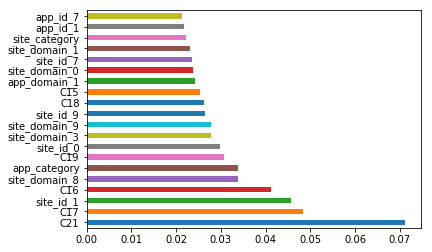

In [58]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20).plot(kind='barh')